In [3]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

In [2]:
chroms= ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY', 'chrM']
chrom_lens = {x.rstrip('\n').split('\t')[0]: int(x.rstrip('\n').split('\t')[1]) for x in
                  open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()}
genome_len = sum(chrom_lens.values())

In [8]:
info = np.array([[0, 0, 0, 0, 0]])
for chrom in chroms:
    for strand in ['positive', 'negative']:
        chrom_info = np.load('../data/snipr/%s_%s_info.npy' % (chrom, strand))
        print (chrom, chrom_info.shape)
        info = np.vstack([info, chrom_info])
info = info[1:]
processed_info = [info[:, 0], info[:, 1], info[:, 2], info[:, 4]+1-info[:, 3]]

chr1 (646364, 5)
chr1 (649077, 5)
chr2 (627887, 5)
chr2 (627753, 5)
chr3 (502387, 5)
chr3 (504183, 5)
chr4 (435063, 5)
chr4 (437005, 5)
chr5 (450976, 5)
chr5 (451655, 5)
chr6 (428234, 5)
chr6 (428383, 5)
chr7 (419546, 5)
chr7 (420159, 5)
chr8 (373589, 5)
chr8 (374614, 5)
chr9 (332567, 5)
chr9 (334295, 5)
chr10 (372865, 5)
chr10 (373842, 5)
chr11 (368168, 5)
chr11 (370074, 5)
chr12 (359423, 5)
chr12 (360345, 5)
chr13 (224780, 5)
chr13 (225481, 5)
chr14 (241663, 5)
chr14 (241522, 5)
chr15 (241457, 5)
chr15 (242380, 5)
chr16 (259226, 5)
chr16 (259721, 5)
chr17 (263347, 5)
chr17 (264841, 5)
chr18 (191543, 5)
chr18 (191322, 5)
chr19 (203854, 5)
chr19 (205865, 5)
chr20 (190513, 5)
chr20 (190138, 5)
chr21 (91767, 5)
chr21 (92773, 5)
chr22 (125338, 5)
chr22 (125883, 5)
chrX (386443, 5)
chrX (386722, 5)
chrY (65711, 5)
chrY (65828, 5)
chrM (12, 5)
chrM (68, 5)


In [9]:
min(processed_info[3]), max(processed_info[3])

(15, 25813)

In [10]:
len(processed_info[0]), sum(processed_info[2]), sum(processed_info[3])

(15626652, 24359271257, 1610165962)

In [11]:
sum(processed_info[3])/(genome_len*2)

0.26006542828239587

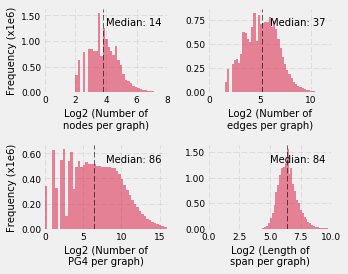

In [12]:
def millions(x, pos):
    return '%1.2f' % (x*1e-6)
formatter = FuncFormatter(millions)

loc = [(0, 0), (0, 1), (1, 0), (1, 1)]
xlims = [(0, 8), (0, 12), (0, 16), (0, 10)]
labels = ['Number of\nnodes per graph', 'Number of\nedges per graph',
          'Number of\nPG4 per graph', 'Length of\nspan per graph',]
fig, axis = plt.subplots(2, 2, figsize=(5,4))
for i in range(4):
    ax = axis[loc[i]]
    ax.hist(np.log2(processed_info[i]), bins=70, edgecolor='none',
            alpha=0.5, color='crimson')
    median = np.median(processed_info[i])
    ax.axvline(np.log2(median), lw=1, ls='--', color='k', alpha=0.6)
    if loc[i][1] == 0:
        ax.set_ylabel('Frequency (x1e6)', fontsize=10)
    ax.set_xlabel('Log2 (%s)' % labels[i], fontsize=10)
    ax.yaxis.set_major_formatter(formatter)
    ax.text(0.5, 0.8, "Median: %d" % median, fontsize=10, transform=ax.transAxes)
    ax.set_xlim(xlims[i])
    clean_axis(ax)

fig.tight_layout()
plt.savefig('../images/properties_distribution.svg', transparent=True, edgecolor='none')
plt.savefig('../images/properties_distribution.png', dpi=300, transparent=True, edgecolor='none')
plt.show()

In [ ]:
from collections import Counter

In [31]:
def load_scores(chrom, strand):
    in_dir = '/home/parashar/scratch/quadcomb/data/snipr'
    fn = '%s/%s_%s_scores.npy' % (in_dir, chrom, strand)
    return np.load(fn)

def load_seq(chrom):
    seq_fn = '/home/parashar/scratch/hg19_resource/chromosomes/%s.fa' % chrom
    seq = [list(x.rstrip('\n')) for x in open(seq_fn).readlines()[1:]]
    return np.array(seq).flatten()

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
for chrom in chroms:
    for strand in ['positive', 'negative']:
        snipr = load_scores(chrom, strand)
        seq = load_seq(chrom)
        nz = np.nonzero(snipr)[0]
        bases = seq[nz]
        counter = Counter(bases)
        break
    break

IndexError: index 4985259 is out of bounds for axis 1 with size 4985013

In [9]:
snipr.shape, len(seq), counter

((249250621,), 249250621)